In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import io, stats
from fooof import FOOOFGroup

sys.path.append('../')
import utils

font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 14}

import matplotlib
matplotlib.rc('font', **font)

In [2]:
def plot_psd_figs(psd_dict, psd_re, p_cur, save_folder):
    for chan in range(psd_dict[p_cur].shape[1]):
        plt.loglog(psd_dict['f_axis'], psd_dict[p_cur][:,chan], 'k', lw=1)
        for psd_re in psds_regen:
            plt.loglog(psd_re[0],psd_re[1][chan,:], '-.', lw=2, alpha=0.8)

        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power (au)')    
        plt.title('Channel: %i'%chan)
        plt.tight_layout()        
        plt.savefig(save_folder+'/chan%i.png'%chan)
        plt.clf()

In [240]:
# load the data variables
basepath = '/Users/rdgao/Documents/data/MNI_rest/'
datafile = basepath + 'WakefulnessMatlabFile.mat'
result_basepath = '/Users/rdgao/Documents/code/research/field-echos/results/MNI_rest/'
data_dict = io.loadmat(datafile, squeeze_me = True)
region_labels = pd.read_csv(basepath+'/WakefulnessInformation/RegionInformation.csv')
region_labels['Region name']=[rl[1:-1] for rl in region_labels['Region name']]
print(data_dict.keys())

dict_keys(['__header__', '__version__', '__globals__', 'AgeAtTimeOfStudy', 'ChannelName', 'ChannelPosition', 'ChannelRegion', 'ChannelType', 'Data', 'FacesLeft', 'FacesRight', 'Gender', 'Hemisphere', 'NodesLeft', 'NodesLeftInflated', 'NodesRegionLeft', 'NodesRegionRight', 'NodesRight', 'NodesRightInflated', 'Patient', 'RegionName', 'SamplingFrequency'])


# Saving out PSD & fooof fit plots
### note: this takes a long time because it's generating and saving thousands of plots

In [4]:
save_psd_plots = False

if save_psd_plots:
    # load in fooof results and regenerate fit psds
    plt.figure(figsize=(6,6))
    for win_len in ['1sec', '5sec']:
        for p_cur in ['psd_mean', 'psd_med']:
            psd_folder = result_basepath+'/psd/'+win_len+'/'
            psd_dict = np.load(psd_folder+'psds.npz')
            fooof_folder = psd_folder+'/fooof/'+p_cur+'/'        
            ff_list = [ff for ff in os.listdir(fooof_folder) if '.json' in ff]
            fgs, psds_regen = [], []
            for ff in ff_list:
                fg = FOOOFGroup()
                fg.load(ff, fooof_folder)
                fgs.append(fg)
                psds_regen.append(utils.return_fooof_regen(fg))

            psd_plot_save_folder = utils.makedir(fooof_folder, 'psd_plots/', timestamp=False)        
            plot_psd_figs(psd_dict, psds_regen, p_cur, psd_plot_save_folder)

# Collect fooof fits and meta info
Note that x,y,z in MNI coord is L-R, P-A, I-S 

In [370]:
win_len, p_cur = '1sec', 'psd_med'
fooof_folder = result_basepath+'/psd/'+win_len+'/fooof/'+p_cur+'/'
print(fooof_folder)
ff_list = [ff for ff in os.listdir(fooof_folder) if '.json' in ff]
print(ff_list)

# return fooof fits and convert knee to tau
fg_aps, fg_pks, fg_err, fg_r2s = utils.return_fg_fits(ff_list[1], fooof_folder)
if fg_aps.shape[1]==3:
    knee_freq, knee_tau = utils.convert_knee_val(fg_aps[:,1],fg_aps[:,2])
else:
    knee_tau = np.zeros_like(fg_aps)[:,0]

# create pandas df and throw everything in there
e_type = np.array(data_dict['ChannelType'], 'c').view(np.uint8)-64.
df_info = np.vstack((data_dict['Patient'], e_type, data_dict['ChannelPosition'].T, data_dict['ChannelRegion'])).T
df_data = np.vstack((fg_aps[:,-1], knee_tau, np.log10(knee_tau), fg_err, fg_r2s)).T
df = pd.DataFrame(np.hstack((df_info,df_data)),columns=['patient','etype', 'x','y','z','region','exp', 'tau','log_tau','err', 'r2'])

/Users/rdgao/Documents/code/research/field-echos/results/MNI_rest//psd/1sec/fooof/psd_med/
['fg_fixed_1pks_30-55Hz.json', 'fg_knee_2pks_1-55Hz.json', 'fg_fixed_2pks_1-55Hz.json', 'fg_fixed_1pks_1-10Hz.json']


../utils.py:55: RuntimeWarning: invalid value encountered in power
  knee_freq = knee**(1./exponent)


# Subject and Grand Average
First average over electrodes of the same region for each subject, then average over all subjects.

Can vary the plotted feature and the central tendency measure used. Error bars always denote 2xSEM.

/Users/rdgao/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:842: RuntimeWarning: Mean of empty slice
  f = lambda x: func(x, *args, **kwargs)


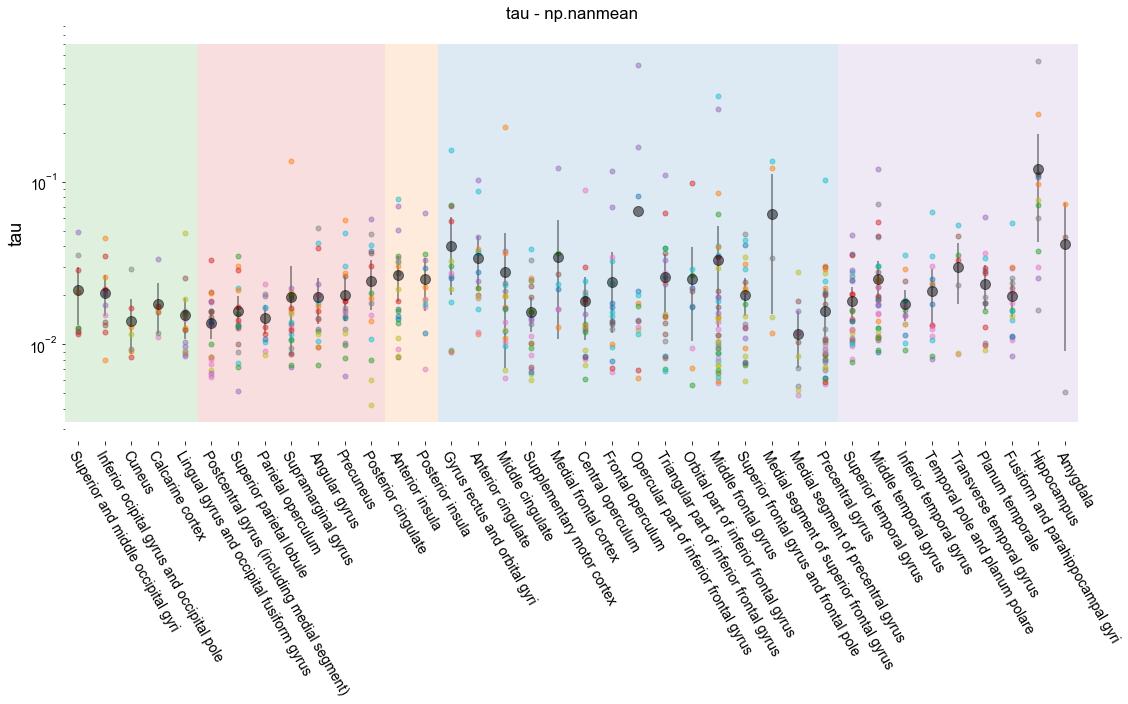

In [377]:
#df.groupby(['region', 'patient']).mean()

plot_feature = 'tau'
aggr_funcs = ['np.nanmean', 'np.nanmedian', 'stats.mstats.gmean']
aggr_func = aggr_funcs[0]
log_y = True
df_region = pd.DataFrame()

plt.figure(figsize=(16,10))
# plot per-subj average
for patient, group in df.groupby('patient'):
    patient_agg = group.groupby(['region']).aggregate(eval(aggr_func))
    df_region = df_region.append(patient_agg)
    plt.plot(patient_agg[plot_feature], 'o', alpha=0.5, label=patient, ms=5)

# plot grand average and sem
grand_agg = df_region.groupby('region')
agg_mean = grand_agg[plot_feature].apply(eval(aggr_func))
agg_std = grand_agg[plot_feature].apply(np.nanstd)/(grand_agg[plot_feature].count()**0.5)*2
plt.errorbar(region_labels['Region #'], agg_mean, yerr=agg_std, fmt='ok', ms=10, alpha=0.5)

if log_y: plt.yscale('log')
    
# label axes & ticks
plt.xticks(region_labels['Region #'], region_labels['Region name'], rotation=300, ha='left', rotation_mode='anchor');
plt.ylabel(plot_feature, fontsize=18)
plt.title(plot_feature + ' - ' + aggr_func)

# plot shading for lobe
YL = plt.ylim()
lobes = np.array([region_labels.groupby('Lobe')['Region #'].min(), region_labels.groupby('Lobe')['Region #'].max()])
for l in lobes.T:
    plt.fill_between([l[0]-0.5, l[1]+0.5], YL[0], YL[1], alpha=0.15)

plt.box('off')
plt.xlim([region_labels['Region #'].min()-0.5, region_labels['Region #'].max()+0.5])
plt.tight_layout()

As far as time constants go, these results seem roughly consistent with the monkey results:
- the numbers themselves are in the range of monkey ecog results, i.e. between 10-100ms mostly, as opposed to 100-300ms of population spiking timescales
- frontal regions, especially mFC and ACC, have the longest fitted time constants.
- SMC and pre+postcentral gyrus (somatosensory areas) have the shortest time constants.
- temporal lobe, as a whole, have pretty long time constants. I would've expected at least a short-timescale region in primary auditory cortex, but maybe coverage there isn't good coverage there. Also I have no clue which of those regions correspond to A1.
- hippocampus has an extremely long time constant as a whole, as well as opercular part of IFG (brodmann 44).
- results are fairly consistent across different averaging functions
- did not look extensively across the different PSD estimate and fooof parameter configurations, but comparing 1sec and 5sec median fits seem to be pretty consistent
- **one potential caveat is electrode difference: the 4 types of electrodes may have different impedance spectra, so I should probably regress that out, or at least compare within electrodes**
- **I have no idea where some of these regions are, maybe plot their average coordinates on a brain?**
- **not really sure what is the best function to use to average/visualize the time constants, because they're non-normally distributed**

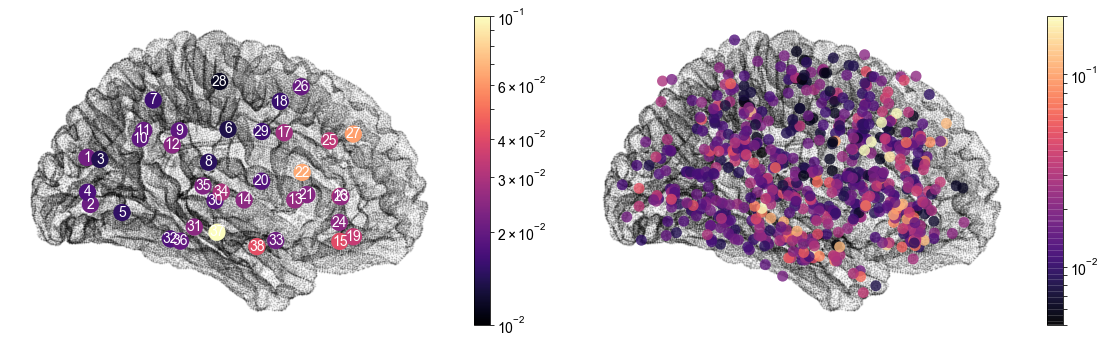

In [461]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.scatter(data_dict['NodesLeft'][:,1],data_dict['NodesLeft'][:,2], s=1, c='k', alpha=0.1)
plt.scatter(grand_agg.mean()['y'],grand_agg.mean()['z'], s=300, c=agg_mean, 
            norm=matplotlib.colors.LogNorm(), edgecolors='none', cmap='magma')

for i,s in enumerate(region_labels['Region #']):
    plt.text(grand_agg.mean()['y'][i+1],grand_agg.mean()['z'][i+1], s, color='w', 
             horizontalalignment='center', verticalalignment='center')
plt.clim([0.01,0.1])
plt.colorbar()
plt.xticks([]);plt.yticks([])
plt.box('off')

plt.subplot(1,2,2)
plt.scatter(data_dict['NodesLeft'][:,1],data_dict['NodesLeft'][:,2], s=1, c='k', alpha=0.1)
plt.scatter(df_region['y'],df_region['z'], s=120, c=df_region[plot_feature], 
            norm=matplotlib.colors.LogNorm(), edgecolors='none', cmap='magma', alpha=0.8)
plt.clim([0.005,0.2])
plt.colorbar()
plt.xticks([]);plt.yticks([])
plt.tight_layout()
plt.box('off')

Text(0,0.5,'Time constant (s)')

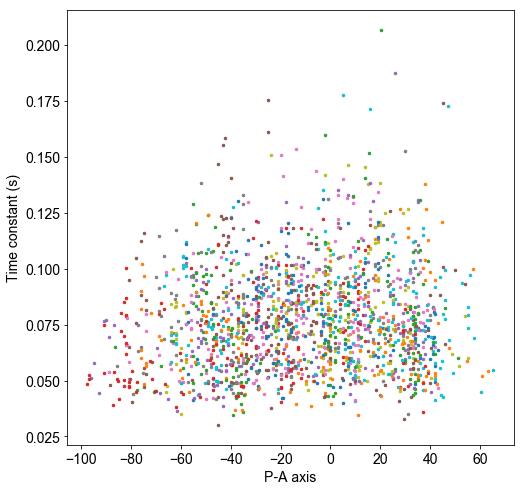

In [375]:
# 'D' for Dixi intracerebral electrodes
# 'M' for homemade MNI intracerebral electrodes
# 'A' fro AdTech intracerebral electrodes 
# 'G' for AdTech subdural strips and grids
plt.figure(figsize=(8,8))
inds = np.logical_and(data_dict['ChannelType']=='M',~np.isnan(knee_freq))
for p in np.unique(data_dict['Patient']):
    inds = np.logical_and(data_dict['Patient']==p,~np.isnan(knee_freq))
    plt.plot(data_dict['ChannelPosition'][inds,1], fg_err[inds], '.', ms=5)

plt.xlabel('P-A axis')
plt.ylabel('Time constant (s)')

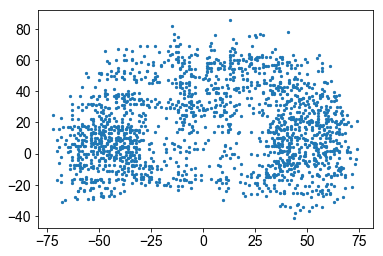

In [27]:
ind = data_dict['ChannelPosition'][:,0]>=-np.inf
plt.scatter(data_dict['ChannelPosition'][ind,0], data_dict['ChannelPosition'][ind,2], 5)

In [28]:
# Extract aperiodic data
aps = fg.get_all_data('aperiodic_params')
exps = fg.get_all_data('aperiodic_params', 'exponent')

# Extract peak data
peaks = fg.get_all_data('peak_params')
cfs = fg.get_all_data('peak_params', 'CF')

# Extract metadata about the model fit
errors = fg.get_all_data('error')
r2s = fg.get_all_data('r_squared')

In [5]:
# load fooof result
fooof_file = 

dict_keys(['__header__', '__version__', '__globals__', 'AgeAtTimeOfStudy', 'ChannelName', 'ChannelPosition', 'ChannelRegion', 'ChannelType', 'Data', 'FacesLeft', 'FacesRight', 'Gender', 'Hemisphere', 'NodesLeft', 'NodesLeftInflated', 'NodesRegionLeft', 'NodesRegionRight', 'NodesRight', 'NodesRightInflated', 'Patient', 'RegionName', 'SamplingFrequency'])
